Basic setup and analysis on rt-iot data. This sheet can be used later to check correlation between specific variables, and which variables seem to be related to our target (if a packet is part of an attack or not)

Link to data: https://archive.ics.uci.edu/dataset/942/rt-iot2022 

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
plt.style.use('bmh')

In [2]:
# Check if data exists, download if required
# fetch dataset
rt_iot2022 = fetch_ucirepo(id=942) 

In [3]:
X = rt_iot2022.data.features
y = rt_iot2022.data.targets

In [4]:
X.info()
# No values are obviously missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 83 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id.orig_p                 123117 non-null  int64  
 1   id.resp_p                 123117 non-null  int64  
 2   proto                     123117 non-null  object 
 3   service                   123117 non-null  object 
 4   flow_duration             123117 non-null  float64
 5   fwd_pkts_tot              123117 non-null  int64  
 6   bwd_pkts_tot              123117 non-null  int64  
 7   fwd_data_pkts_tot         123117 non-null  int64  
 8   bwd_data_pkts_tot         123117 non-null  int64  
 9   fwd_pkts_per_sec          123117 non-null  float64
 10  bwd_pkts_per_sec          123117 non-null  float64
 11  flow_pkts_per_sec         123117 non-null  float64
 12  down_up_ratio             123117 non-null  float64
 13  fwd_header_size_tot       123117 non-null  i

In [5]:
unqi = X.nunique(axis=0)
for i in range(len(unqi)):
    if unqi[i] <= 1:
        print("Removing", X.axes[1][i])
        del X[X.axes[1][i]]
        
# bwd_URG_flag count is always the same, usually removed

Removing bwd_URG_flag_count


/tmp/ipykernel_2640613/2926001140.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unqi[i] <= 1:


In [6]:
# Seperate out continous and discrete variables, and graph seperately
continuous_vars = rt_iot2022.variables[rt_iot2022.variables['type'] == "Continuous"]['name'].tolist()

non_continuous = X.drop(columns=continuous_vars)
continuous = X[continuous_vars]

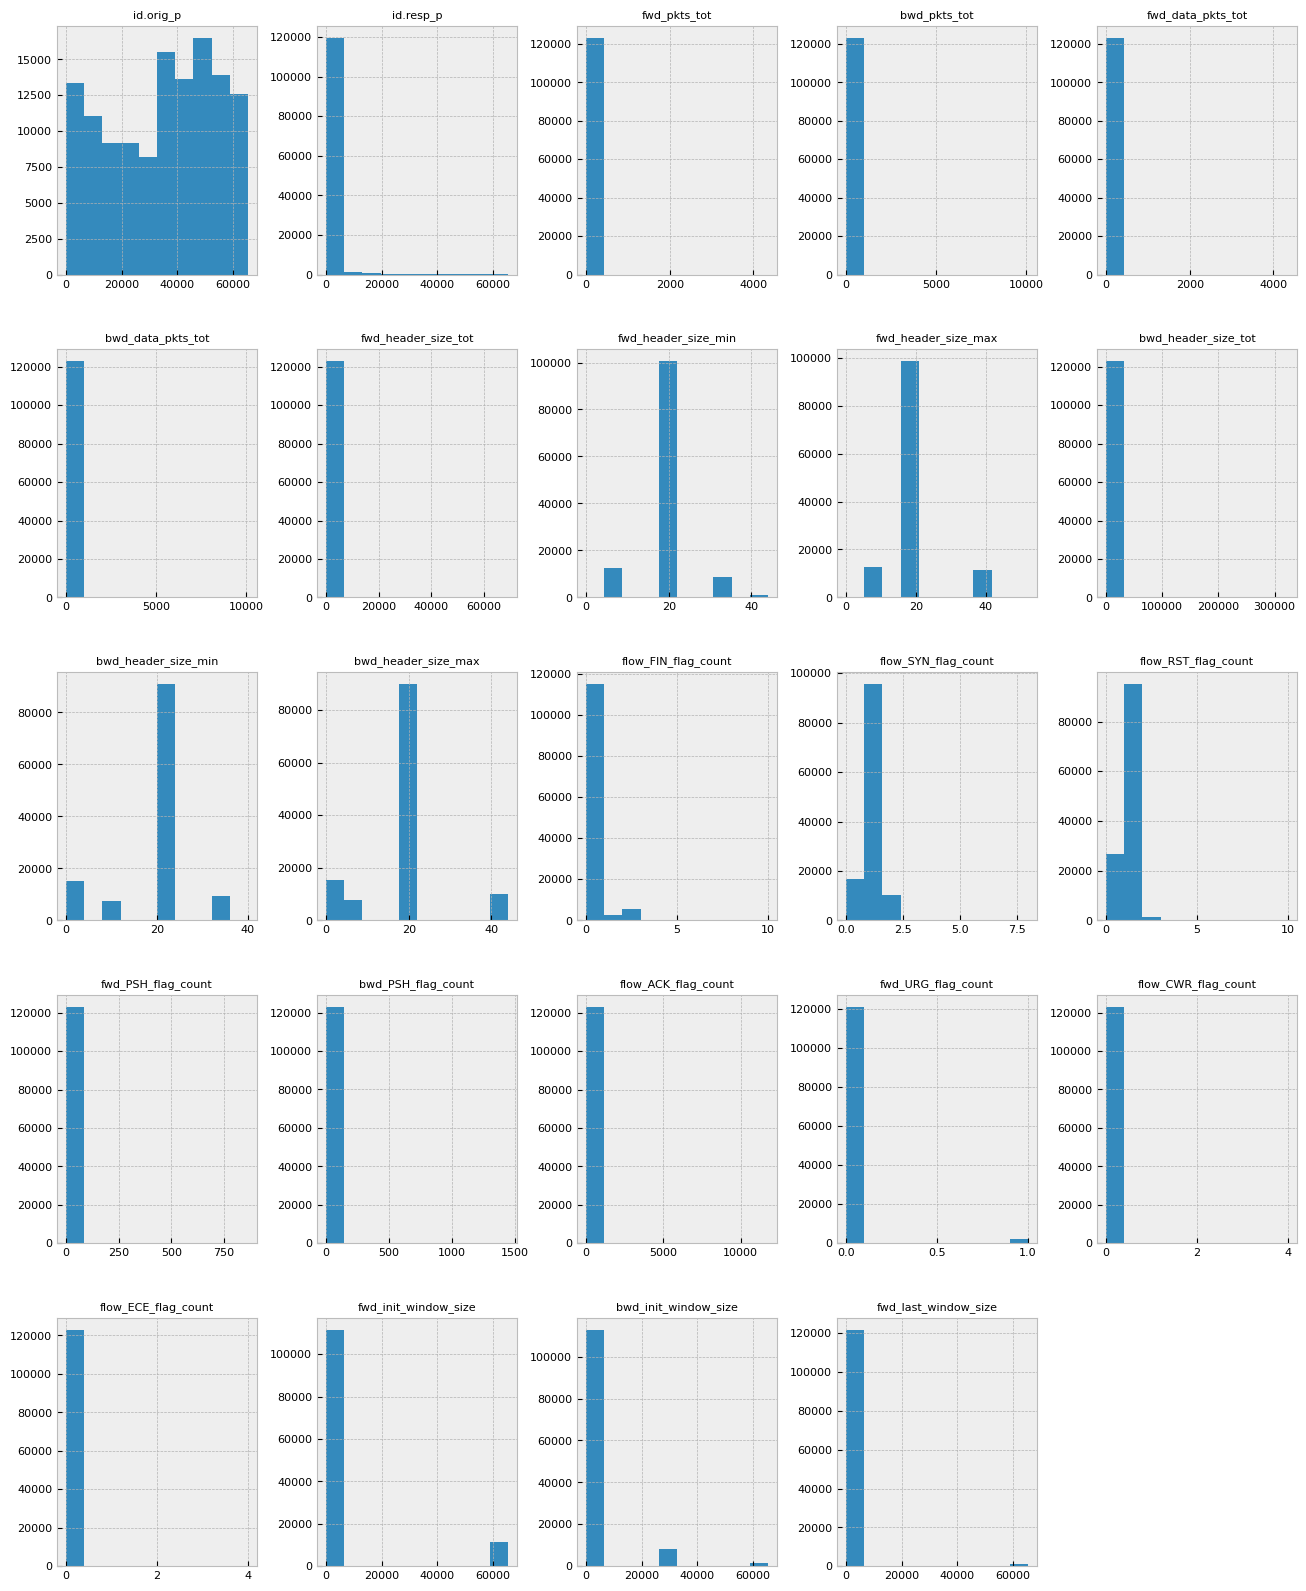

In [7]:
fig = non_continuous.hist(xlabelsize=8, ylabelsize=8, bins=10, figsize=(16,20),sharex=False, sharey=False)
[x.title.set_size(8) for x in fig.ravel()]
plt.show()

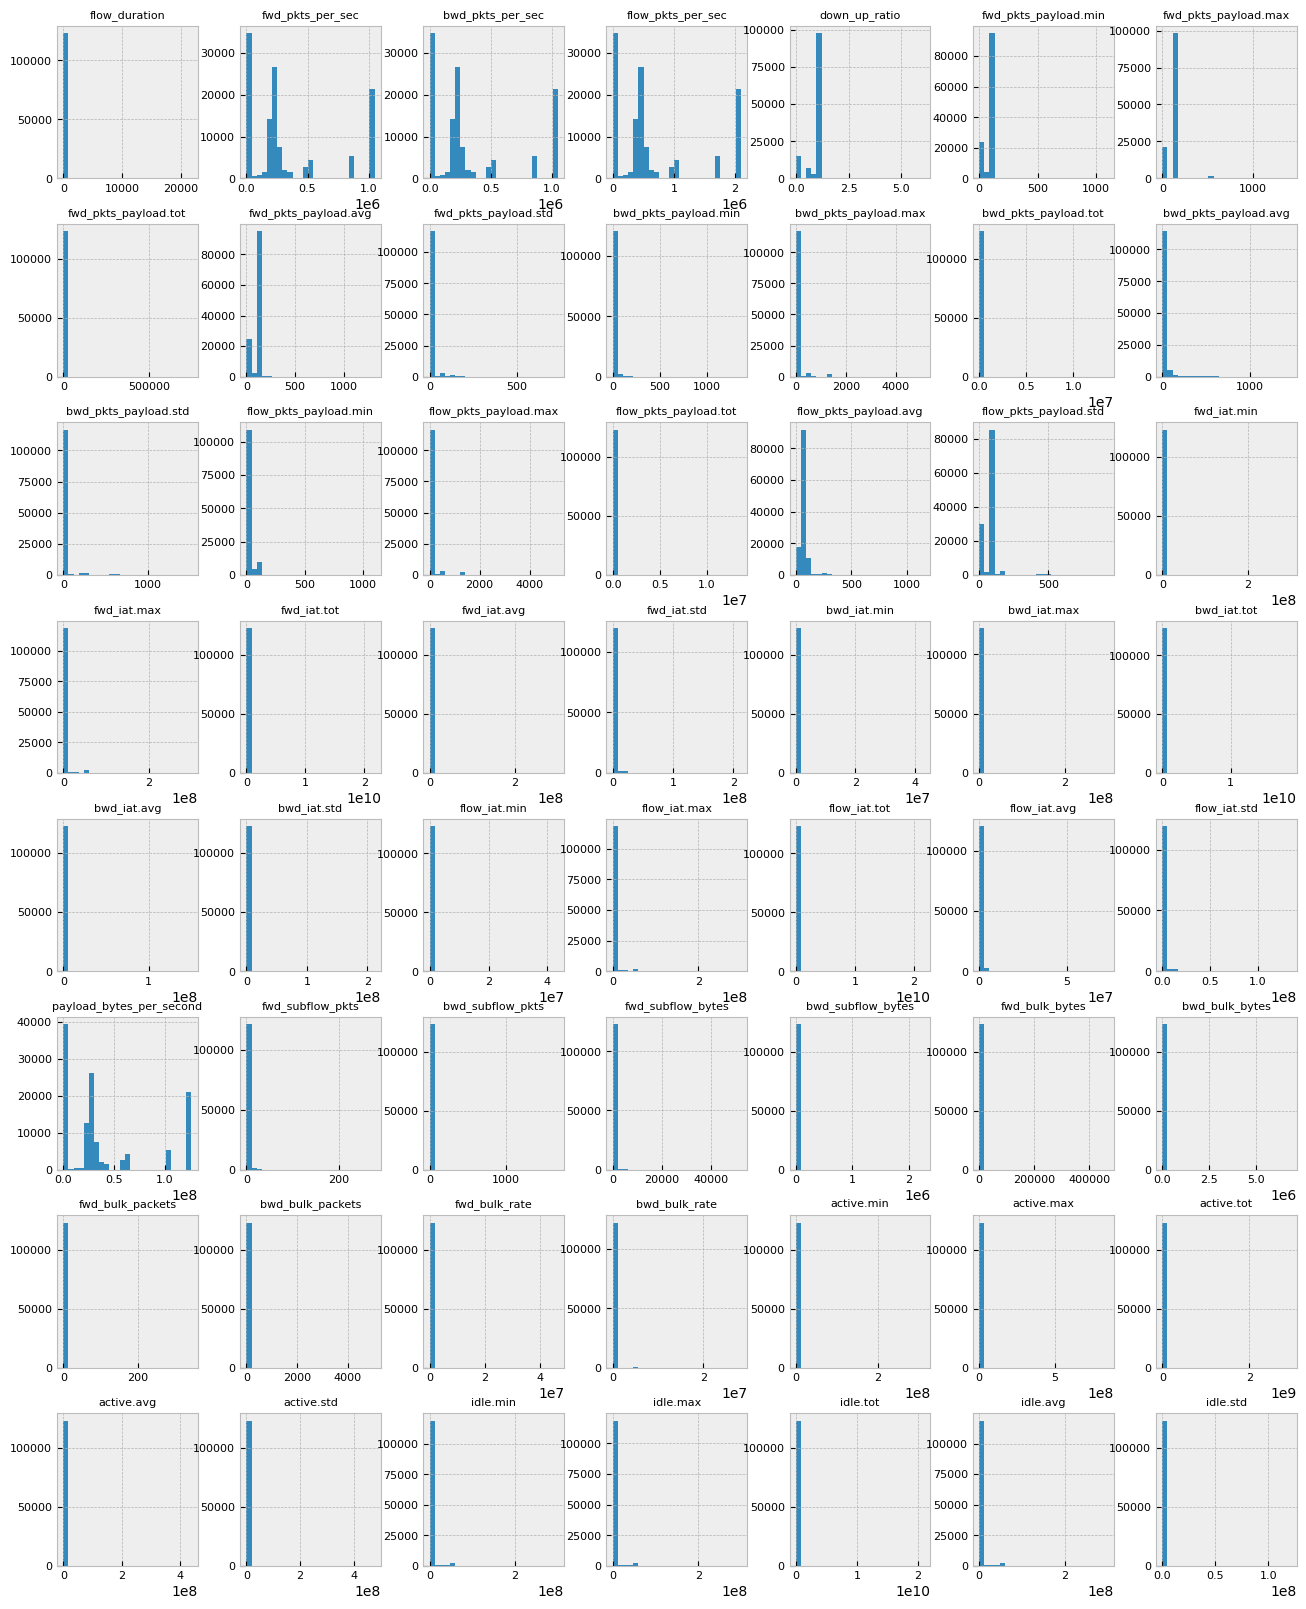

In [8]:
fig = continuous.hist(xlabelsize=8, ylabelsize=8, bins=25, figsize=(16,20),sharex=False, sharey=False)
[x.title.set_size(8) for x in fig.ravel()]
plt.show()

Most values seem to have a high peak at one point, with a few scattered other values. However, I elect to keep most of the variables for now until more analysis is done because those outlier values could hold valuable data

In [9]:
# Find the variables with the highest correlation to attacks to find what might be important to focus on
numerical = X.select_dtypes(include=['float64', 'int64'])

normal_patterns = ["MQTT_Publish", "Thing_speak", "Wipro_bulb_Dataset", "Amazon-Alexa"]

y_bool = [int(x in normal_patterns) for x in y.values]
y_bool = pd.DataFrame(y_bool, columns=["isNormal"])

# Note that these correlations are only for initial analysis, and may be effected by categorical variables
corr = {}
for axis in iter(numerical.axes[1]):
    corr[axis] = y_bool['isNormal'].corr(numerical[axis])

corr = pd.DataFrame.from_dict([corr]).transpose()
print("The values with the highest correlation to attacks are:")
print(corr.sort_values(by=0, ascending=False)[0:10])

print("\n\nThe values with the lowest correlation to attacks are:")
print(corr.sort_values(by=0, ascending=True)[0:5])

The values with the highest correlation to attacks are:
                             0
idle.min              0.817971
idle.avg              0.803456
fwd_iat.max           0.790008
flow_iat.max          0.788098
idle.max              0.785732
fwd_iat.std           0.763877
flow_iat.std          0.760193
flow_iat.avg          0.604637
fwd_init_window_size  0.578326
fwd_header_size_max   0.499183


The values with the lowest correlation to attacks are:
                              0
fwd_pkts_payload.min  -0.396886
fwd_pkts_payload.avg  -0.375039
flow_pkts_payload.avg -0.211974
fwd_pkts_per_sec      -0.177133
flow_pkts_per_sec     -0.177114


In [10]:
numerical = pd.concat([numerical, y_bool], axis=0)

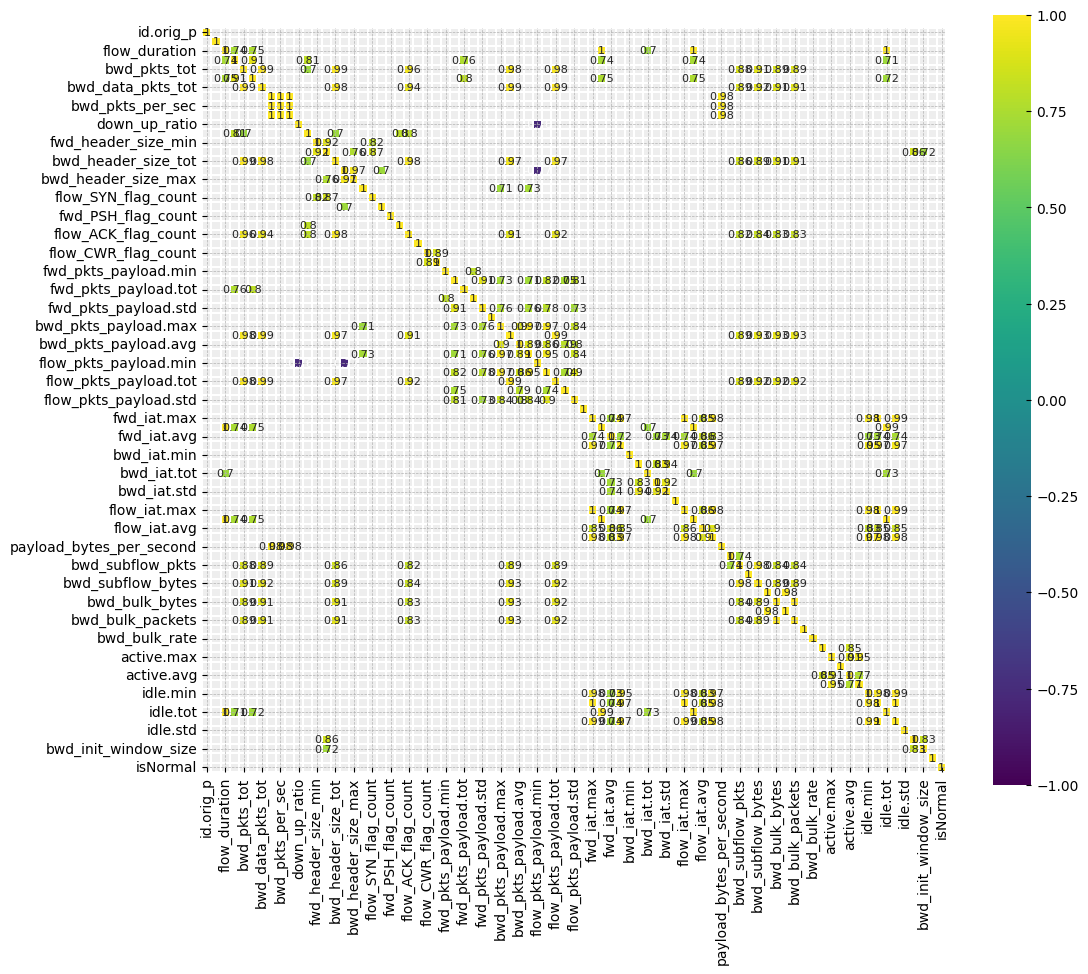

In [11]:
# TODO: fix this
# plot the relationship between high correlation values and attack status

corr2 = numerical.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr2[(corr2 >= .7) | (corr2 <= -.7)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);


In [12]:
# list Values with high correlation between each other (text form of the above graph)
# Show values with high correlation to 'flow duration' as an example, can be used on other variables
stacked = corr2.stack()
intervariable_corr = stacked[(stacked > .7) & (stacked <= .99)]
print(intervariable_corr['flow_duration'])

fwd_pkts_tot         0.741707
fwd_data_pkts_tot    0.754355
bwd_iat.tot          0.701750
dtype: float64
